In [1]:
import os
import time

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler

from chord_recognition.container import ContextContainer
from chord_recognition.dataset import AudioDataset, MirexFameDataset
from chord_recognition.utils import get_chord_labels
from models.cnn import model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
model.load_state_dict(torch.load('results/etd_best_model.pt', map_location=device))
model.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (bnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (bnorm5): BatchNorm2

In [12]:
# chord_dataset = AudioDataset(audio_dir="data/robbie_williams/mp3/2000-Sing When You're Winning/",
#                              ann_dir="data/robbie_williams/chordlabs/2000-Sing When You're Winning/",
#                              window_size=8192, hop_length=4096)
chord_dataset = AudioDataset(audio_dir="data/queen/mp3/Greatest_Hits_II/",
                             ann_dir="data/queen/chordlabs/Greatest_Hits_II/",
                             window_size=8192, hop_length=4096)
# chord_dataset = AudioDataset(audio_dir="data/beatles/mp3/Greatest_Hits_II/",
#                              ann_dir="data/beatles/chordlabs/Greatest_Hits_II/",
#                              window_size=8192, hop_length=4096)
loader_chord = DataLoader(chord_dataset, batch_size=None, num_workers=0)
sampler = SequentialSampler(chord_dataset)

In [44]:
@torch.no_grad()
def compute_chromagram(spectrogram, model, device, batch_size=32, context_size=7, num_classes=25):
    criterion = nn.Softmax()
    container = ContextContainer(spectrogram, context_size)
    result = []
    
    frames = np.asarray([f.reshape(1, *f.shape) for f in container])
    sampler = SequentialSampler(frames)
    sampler = BatchSampler(sampler, batch_size=batch_size, drop_last=False)
    for idx in sampler:
        inputs = torch.from_numpy(frames[idx]).to(device=device, dtype=torch.float32)
        scores = model(inputs)
        scores = criterion(scores)
        scores = scores.squeeze(3).squeeze(2)
        result.append(scores)

    result = torch.cat(result)
    preds = torch.argmax(result, 1)
    result = F.one_hot(preds, num_classes).t_()
    return result.data.numpy()

In [39]:
from metrics import compute_eval_measures


def estimate_chords(dataloader, model, device, batch_size=32,
                    drop_last=False, scores_dir='scores'):
    model.eval()  # set model to evaluation mode
    
    for idx in dataloader:
        sample = dataloader.data_source[idx]
        sample_name = sample['sample']
        chromagram = sample['chromagram']
        
        result = compute_chromagram(chromagram, model, device, batch_size=batch_size)
        ann_matrix = sample['ann_matrix']
        
        P, R, F1, TP, FP, FN = compute_eval_measures(ann_matrix, result)
        title = f'Eval: (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f) - {sample_name}' % (result.shape[1], TP, FP, FN, P,R,F1)
        print(title)

In [38]:
estimate_chords(sampler, model, device, batch_size=8)

Eval: (N=2822, TP=2188, FP=634, FN=58, P=0.775, R=0.974, F=0.863) - 01 A Kind Of Magic
Eval: (N=2600, TP=1814, FP=786, FN=66, P=0.698, R=0.965, F=0.810) - 04 I Want It All
Eval: (N=2786, TP=2613, FP=173, FN=78, P=0.938, R=0.971, F=0.954) - 05 I Want To Break Free
Eval: (N=3198, TP=1477, FP=1721, FN=15, P=0.462, R=0.990, F=0.630) - 09 Who Wants To Live Forever
Eval: (N=2370, TP=1388, FP=982, FN=26, P=0.586, R=0.982, F=0.734) - 14 Hammer To Fall
Eval: (N=2681, TP=1649, FP=1032, FN=49, P=0.615, R=0.971, F=0.753) - 15 Friends Will Be Friends


In [ ]:
def calculate_chords(model, audio_path, ann_path, window_size=8192, hop_length=4096):
    from utils import convert_chord_ann_matrix
    audio_waveform, sampling_rate = librosa.core.load(audio_path, sr=None)
    chromagram = librosa.feature.chroma_stft(audio_waveform, sr=sampling_rate, norm=None,
                                             n_fft=window_size, hop_length=hop_length, tuning=0, n_chroma=105)
    criterion = nn.Softmax()
    container = ContextContainer(chromagram, 7)
    result = torch.empty(25, chromagram.shape[1])
    for idx, frame in enumerate(container):
        frame = frame.reshape(1, 1, *frame.shape)

        inputs = torch.from_numpy(frame)
        scores = model(inputs)

        scores = torch.squeeze(scores)
        scores = criterion(scores)
        result[:, idx] = scores

    _, preds = torch.max(result, 0)
    result = F.one_hot(preds, result.shape[0]).t_()
    result = result.data.numpy()
    
    
    chord_labels = get_chord_labels(ext_minor='m', nonchord=True)
    N_X = chromagram.shape[1]
    Fs_X = sampling_rate / hop_length
    ann_matrix, _, _, _ = convert_chord_ann_matrix(
            fn_ann=ann_path, chord_labels=chord_labels, Fs=Fs_X, N=N_X, last=False)
    return result, ann_matrix

In [ ]:
def print_chords(chord_matrix):
    chord_labels = get_chord_labels(nonchord=True)
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    ax.set_yticks(np.arange(len(chord_labels)))
    ax.set_yticklabels(chord_labels)
    ax.set_title('Time–chord representation of chord recognition result')
    ax.pcolormesh(chord_matrix, cmap='coolwarm', alpha=0.7)

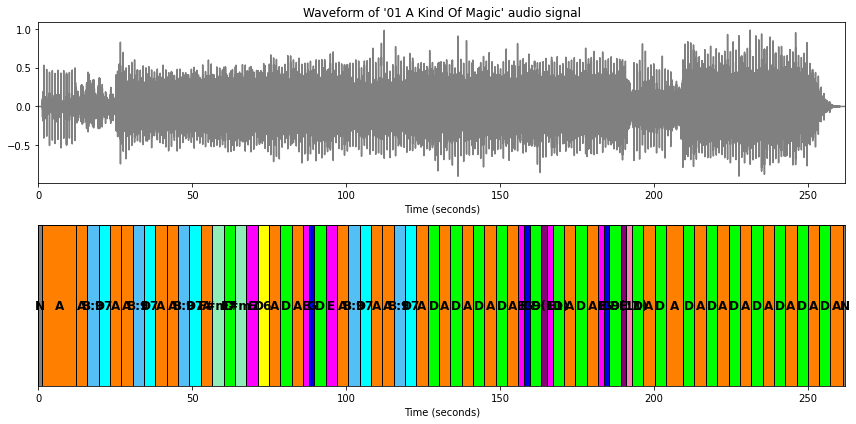

In [40]:
from plot import plot_matrix, plot_segments, plot_signal

sample = chord_dataset[0]  # just a random sample
sample_name = sample['sample']
Fs = sample['Fs']
X = sample['audio_waveform']

H = chord_dataset.hop_length
ann_seg_sec = sample['ann_seg_sec']
x_dur = X.shape[0] / Fs

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_signal(x=X, Fs=Fs, ax=ax[0], title=f"Waveform of '{sample_name}' audio signal")
plot_segments(ann_seg_sec, ax=ax[1], time_label='Time (seconds)', time_max=x_dur)
plt.tight_layout()

In [41]:
chromagram = sample['chromagram']
chromagram = compute_chromagram(chromagram, model, device, batch_size=8)

In [46]:
chromagram.shape

(25, 2822)